<a href="https://colab.research.google.com/github/vedantdave77/PROJECT_Financial_Fraud_Analysis-/blob/master/Fraud_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the project on kaggle data set which is publicly available for the fraud detection analysis. The highly imbalanced data consist more than 6 million rows of data with 11 columns.

I use concept of feature engineering with gradient booster machine learning algorithm form dicision tree branch ( A gradient boooster decisiont tree) 

I get help and intution from the Arjun Joshua's notebook. 



## Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

Import Data and give understandable columns names

In [3]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig': 'newBalanceOrig','oldbalanceDest':'oldBalanceDest','newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Now, test the null value from the Frame. (finding a missing value)


In [39]:
df.shape

(6362620, 11)

In [4]:
df.isnull().values.any()


False

## Explotary Data Analysis
wrangling data for data insights

Our first question is which kind of transactions are fraud ... from some great reposatories we can obeserve the pattern that most of the case have one transfer to another acount transfer and then cashout procedure happen.

So our focus must be on the TRANSFER , CASH_OUT, columns because it takes relation between acount and remarkably the number of fraudulent TRANSFER arealmost equal to the fraudulent CASH_OUTs.

In [5]:
print('The types of fraudulent transactions are {}'.format(list(df.loc[df.isFraud ==1].type.drop_duplicates().values)))

dfFraudTransfer = df.loc[(df.isFraud ==1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud ==1) & (df.type == 'CASH_OUT')]

print('')
print('The number of fraudulant TRANSFERs = {}'.format(len(dfFraudTransfer)))
print('')
print('The number of fraudulent CASH_OUT = {}'.format(len(dfFraudCashout)))

The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

The number of fraudulant TRANSFERs = 4097

The number of fraudulent CASH_OUT = 4116


### Check out for flagged fraud


In [6]:
x = len(df.loc[df.isFlaggedFraud ==1])
print( 'Total No. of flagged frauds are {}'.format(x))

Total No. of flagged frauds are 16


Out of 6 million entries only 16  flagged fruads so there is very less chance of correlaton with other entries. As per predefined condition when the entry is more than 200,000 in a one time is considered as Flagged generation at the time of Fraud.

In [7]:
print('')
print('The type of transactions in which isFlaggedFraud is set: {}'.format(list(df.loc[df.isFlaggedFraud==1].type.drop_duplicates())))


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']


In [8]:
dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud ==1]
dfNotFlagged =df.loc[df.isFlaggedFraud ==0]

print('')
print('Min amount transacted when isFlaggedFraud is set = {}'.format(dfFlagged.amount.min()))
print('')
print('Max amount transacted in a TRANSFER where FlaggedFraud is set= {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud ==0].amount.max()))


Min amount transacted when isFlaggedFraud is set = 353874.22

Max amount transacted in a TRANSFER where FlaggedFraud is set= 92445516.64


For every such transaction the oldBalanceDest and newBalanceDest must be 0 because after fraud flagged the transactions were haulted.

In [9]:
print('')
print('The number of TRANSFERs where (isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0) are: {}'.format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud ==0) & (dfTransfer.oldBalanceDest ==0) & (dfTransfer.newBalanceDest ==0)])))


The number of TRANSFERs where (isFlaggedFraud = 0, yet oldBalanceDest = 0 and newBalanceDest = 0) are: 4158


Now compare the balance of min and max of flagged and non-flagged entries are...

In [10]:
print('')
print('Min, Max of oldBalaceOfig for isFlaggedFraud =1 TRANSFERS:{}'.format([round(dfFlagged.oldBalanceOrig.min()), round(dfFlagged.oldBalanceOrig.max())]))

print('')
print('Min, Max of oldBalanceOrig for isFalggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: {}'.format(\
[dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
== dfTransfer.newBalanceOrig)].oldBalanceOrig.min(), \
round(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldBalanceOrig \
               == dfTransfer.newBalanceOrig)].oldBalanceOrig.max())]))



Min, Max of oldBalaceOfig for isFlaggedFraud =1 TRANSFERS:[353874, 19585040]

Min, Max of oldBalanceOrig for isFalggedFraud = 0 TRANSFERs where oldBalanceOrig = newBalanceOrig: [0.0, 575668]


There are one important point is about name of trnasactor is not exist for fraud transaction but du;oicate customer name must exist where isflagged not set.

Moreover, in most of the case try of fraud for one account is only for one time and there is only little chance of more than one attempt. So,lets check how many such acounts really exist....

In [11]:
print('Have originators of transactions flagged as fraud transacted more than once? {}'\
.format((dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig, \
                                    dfNotFlagged.nameDest]))).any()))
# to check is there not flagged person name in flagged activities
print('')

print('Have destinations for transactions flagged as fraud initiated other transactions? {}'\
      .format((dfFlagged.nameDest.isin(dfNotFlagged.nameOrig)).any()))
# to check that the same flaged account did any non flagged transactions?

Have originators of transactions flagged as fraud transacted more than once? False

Have destinations for transactions flagged as fraud initiated other transactions? False


NO such acount exist...Now check that how many account have more than one attempts?

In [12]:
print('How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: {}'\
.format(sum(dfFlagged.nameDest.isin(dfNotFlagged.nameDest))))

# can not use len because it will give all '1' and '0' elements


How many destination accounts of transactions flagged as fraud have been destination accounts more than once?: 2


Kaggle dataset stated that the CASH_OUT all time done by merchants so first we shoud check the doubt of involvement of merchants ('M' prefix) in such activity

In [13]:
print('Are there any merchants among originator accounts for CASH_IN transactions? {}'\
      .format((df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) 

print('')
print('Are there any merchants among destination accounts for CASH_OUT transactions? {}'\
      .format((df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any()))

Are there any merchants among originator accounts for CASH_IN transactions? False

Are there any merchants among destination accounts for CASH_OUT transactions? False


Let's make surity of merchant's involvement during transaction sending end and other activity except PAYMENT

In [14]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any()))


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


Its quiet obvious that one side of the payment transfer destination account also directly used for cashout. so , let's check such scenario...

In [15]:
print('Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]

Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


Some genuine acounts also get money from the Fraud transfer and we must consider that counts...

In [16]:
print('Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: \n\n{}'\
      .format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))

# consider duplication because in one month duration most account holder use it more than one time.

Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount  ... newBalanceDest  isFraud  isFlaggedFraud
1030443    65  TRANSFER  1282971.57  ...            0.0        1               0
6039814   486  TRANSFER   214793.32  ...            0.0        1               0
6362556   738  TRANSFER   814689.88  ...            0.0        1               0

[3 rows x 11 columns]


Oh! wow! Then why we can not see the same analysis further in namedest ,nameorig logic?

In [17]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig =='C423543548')].step.values))

print('\nFraudulent TRANSFER to C1714931087 occured at step = 65 whereas genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig =='C1714931087')].step.values))

print('\nFraudulent TRANSFER to C1023330867 occured at step = 738 whereas genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig =='C1023330867')].step.values))



Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]

Fraudulent TRANSFER to C1714931087 occured at step = 65 whereas genuine CASH_OUT from this account occured earlier at step = [546]

Fraudulent TRANSFER to C1023330867 occured at step = 738 whereas genuine CASH_OUT from this account occured earlier at step = [132]


How ever here is catch that first genuine CASH_OUT happened and then fraud transfer happened so it's not shown in nameorig and namedest features. then check actual step of transaction happening.

# Data Cleaning

From Explotary data analysis of section 2 we know that fraud only occurs in TRANSFER and CASH_OUT so no need of any other columns in the analysis. 

In [ ]:
X = df.loc[(df.type == 'TRANSFER')| (df.type == 'CASH_OUT')]

randomState =5
np.random.seed(randomState)

Y = X['isFraud']
del X['isFraud']

X = X.drop(['nameOrig','nameDest','isFlaggedFraud'],axis =1)

X.loc[X.type == 'TRANSFER','type'] =0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int)

Other observation is about zero balances transaction that in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero denotes a missing value, is much larger in fraudulent compare to genuine trasactions.

In [19]:
Xfraud = X.loc[Y==1]
XnonFraud = X.loc[Y==0]
print('')
print('The fraction of fraudulant transactions with old balanceDest =newBalanceDest =0 although \
although the trasacted amount is non-zero is:{}'\
.format(len(Xfraud.loc[(Xfraud.oldBalanceDest ==0) & (Xfraud.newBalanceDest ==0)\
                       & (Xfraud.amount)])/(len(Xfraud))))


The fraction of fraudulant transactions with old balanceDest =newBalanceDest =0 although although the trasacted amount is non-zero is:0.4955558261293072


In [20]:
print('The fraction of fraudulant transactions with old balanceDest =newBalanceDest =0 although \
although the trasacted amount is non-zero is:{}'\
.format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest ==0) & (XnonFraud.newBalanceDest ==0)\
                       & (XnonFraud.amount)])/(len(XnonFraud))))

The fraction of fraudulant transactions with old balanceDest =newBalanceDest =0 although although the trasacted amount is non-zero is:0.0006176245277308345


From above we can conclude that the zero current balance is strongest indicator of Fraud. But if we think about ML modeling then its better to convert all such zero into -1 so they can easily be classify during our Machine learning algorithms

In [ ]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig ==0) & (X.amount != 0), ['oldBalanceOrig','newBalanceOrig']] = -1

Now replace 0 with null values so our data will separate null and zero balance easily now

In [ ]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig ==0) & (X.amount != 0), ['oldBalanceOrig','newBalanceOrig']] = np.nan

# Feature Engineering

I here create two new features of error as per true transactions the account balance difference must be equal to current balance and if their differnce is not same then  beside zero it will give some value.

In [ ]:
X['errorBalanceOrig'] = X.newBalanceOrig +X.amount -X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest +X.amount -X.newBalanceDest

In [24]:
X.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,300850.89,-2401220.0


# Data Visualization

In [ ]:
# import this define function from other notebook and changed name accordingly 

limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

Now plot our data for transfer and cashout with genuine and fraudulent transaction over time

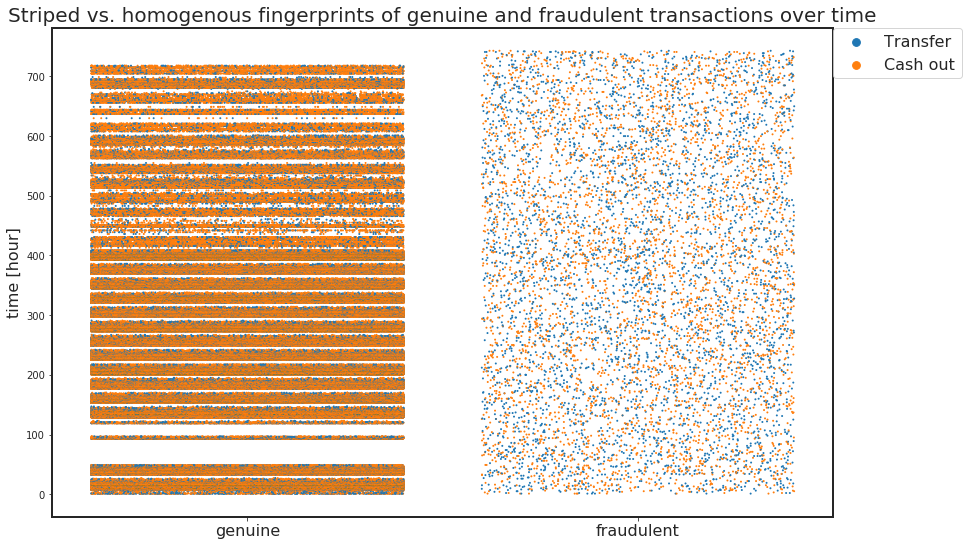

In [26]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);


Dispersion over amount"
by considering transfer and cashout VS fraud data 

HERE : limit is whole X dataset

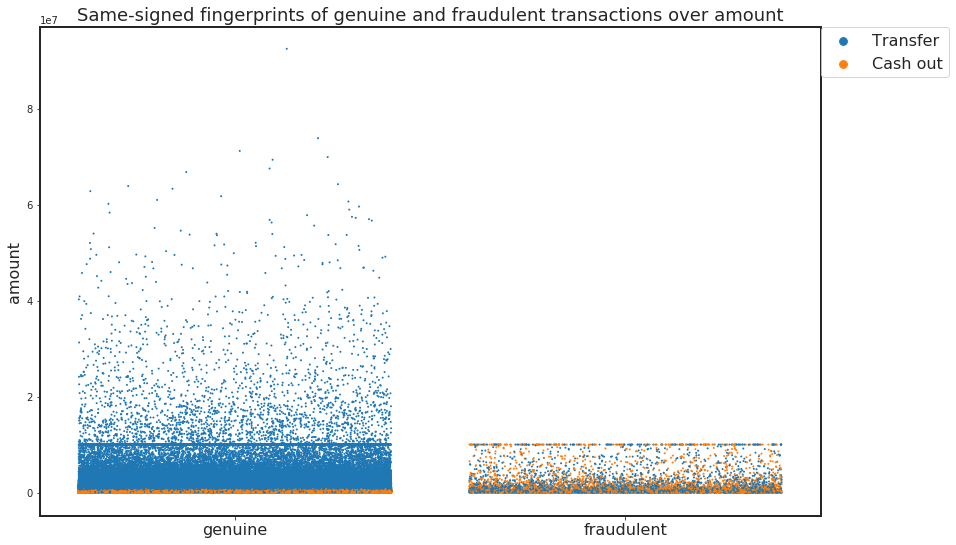

In [27]:
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);


Analysis : Most of data are taken by cash after transfer and after transfer it may done for more than one time( may be due to one time limit amount for cash) 

Now separate genuine data from fraudulent dataset

/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

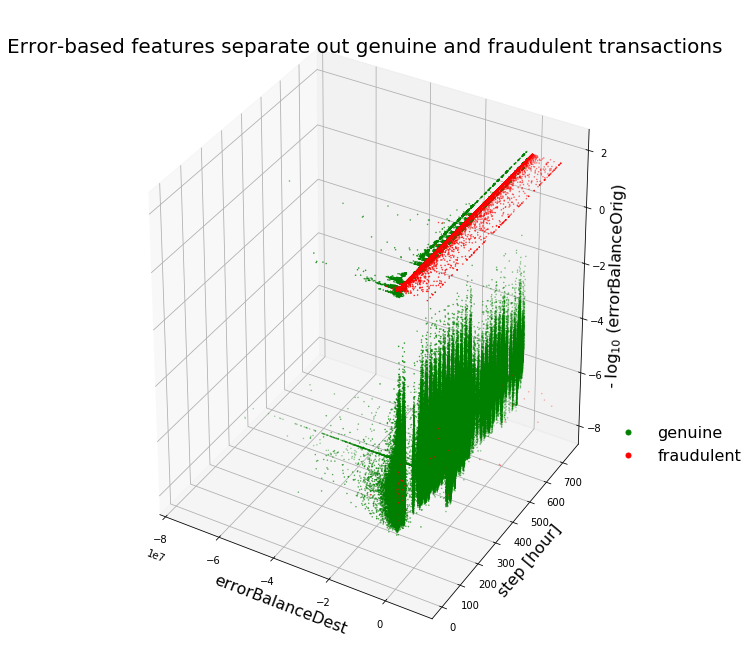

In [29]:
#---------------------------------------Define Figure for 3D -----------------------------------------------------------

x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02
limit = len(X)

sns.reset_orig() # prevent seaborn from over-riding mplot3d defaults

fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

#-------------------------Ploting Values--------------------------------------------------

ax.scatter(X.loc[Y == 0, x][:limit], X.loc[Y == 0, y][:limit], \
  -np.log10(X.loc[Y == 0, z][:limit] + zOffset), c = 'g', marker = '.', \
  s = 1, label = 'genuine')
    
ax.scatter(X.loc[Y == 1, x][:limit], X.loc[Y == 1, y][:limit], \
  -np.log10(X.loc[Y == 1, z][:limit] + zOffset), c = 'r', marker = '.', \
  s = 1, label = 'fraudulent')

#---------------------------Modifying for Understanding-------------------------------------------------

ax.set_xlabel(x, size = 16); 
ax.set_ylabel(y + ' [hour]', size = 16); 
ax.set_zlabel('- log$_{10}$ (' + z + ')', size = 16)
ax.set_title('Error-based features separate out genuine and fraudulent \
transactions', size = 20)

plt.axis('tight')
ax.grid(1)

#--------------------------Give Visual Features to the Plot ---------------------------------------------------

noFraudMarker = mlines.Line2D([], [], linewidth = 0, color='g', marker='.',
                          markersize = 10, label='genuine')

fraudMarker = mlines.Line2D([], [], linewidth = 0, color='r', marker='.',
                          markersize = 10, label='fraudulent')

plt.legend(handles = [noFraudMarker, fraudMarker], \
           bbox_to_anchor = (1.20, 0.38 ), frameon = False, prop={'size': 16});

## Please Refer [  https://pythonspot.com/3d-scatterplot/  ] for this plot

Let's make heat map function for each fearues ( for genuine and fraud data )

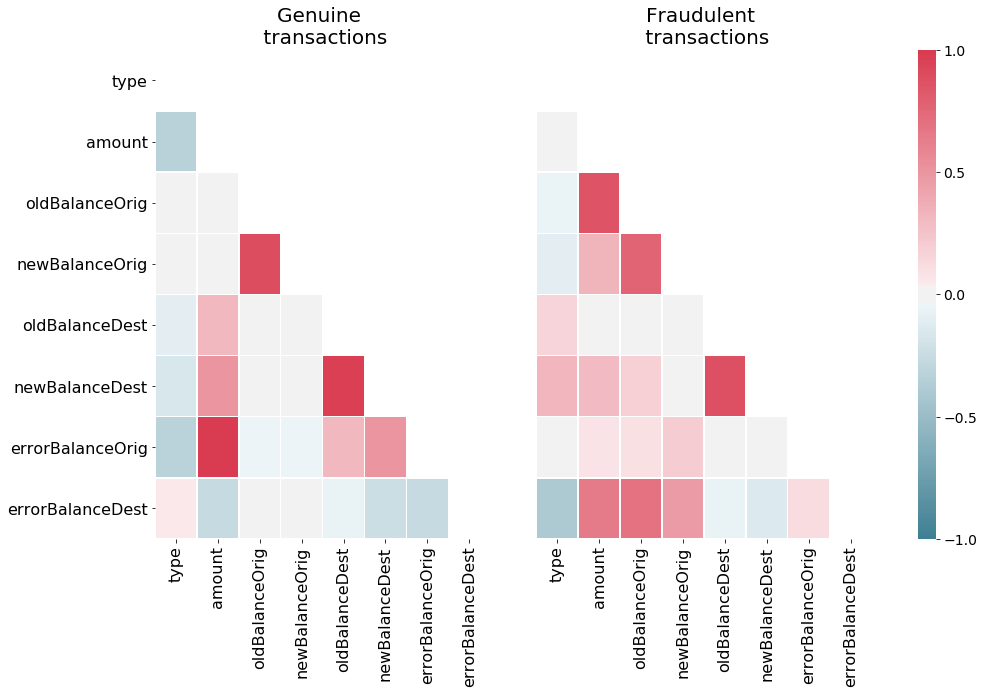

In [30]:
Xfraud = X.loc[Y == 1] # update Xfraud & XnonFraud with cleaned data
XnonFraud = X.loc[Y == 0]

#----------------------------Correlation Non fraud------------------------------------------------------                  

correlationNonFraud = XnonFraud.loc[:, X.columns != 'step'].corr()
mask = np.zeros_like(correlationNonFraud)
indices = np.triu_indices_from(correlationNonFraud)
mask[indices] = True

grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
f, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, gridspec_kw=grid_kws, \
                                     figsize = (14, 9))

cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax1 =sns.heatmap(correlationNonFraud, ax = ax1, vmin = -1, vmax = 1, \
    cmap = cmap, square = False, linewidths = 0.5, mask = mask, cbar = False)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 16); 
ax1.set_yticklabels(ax1.get_yticklabels(), size = 16); 
ax1.set_title('Genuine \n transactions', size = 20)

#--------------------------------Coorelaton Fruad -------------------------------------------------

correlationFraud = Xfraud.loc[:, X.columns != 'step'].corr()
ax2 = sns.heatmap(correlationFraud, vmin = -1, vmax = 1, cmap = cmap, \
 ax = ax2, square = False, linewidths = 0.5, mask = mask, yticklabels = False, \
    cbar_ax = cbar_ax, cbar_kws={'orientation': 'vertical', \
                                 'ticks': [-1, -0.5, 0, 0.5, 1]})
ax2.set_xticklabels(ax2.get_xticklabels(), size = 16); 
ax2.set_title('Fraudulent \n transactions', size = 20);

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size = 14);

# Machine Learning Modeling

Most of the time main problem for machine learning algorithm is skew data. So let's check it

In [31]:
 print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002964544224336551


Due to high amount of skew data imbalance of data happen and that scenario always make obstacle for machine learning model perormance.  So there are sevaral mehtods for imbalance data, one of them is oversampling a
imbeam library has SMOTE technique (oversampling technique)  to correct the imbalance. 

In [ ]:
import sklearn 
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = randomState)

In [33]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
y_hat = clf.fit(X_train, Y_train).predict_proba(X_test)
print('AUPRC = {}'.format(average_precision_score(Y_test,  y_hat[:, 1])))

AUPRC = 0.998596538566699


In [34]:

trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), X_train,\
                                         Y_train, scoring = 'average_precision')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


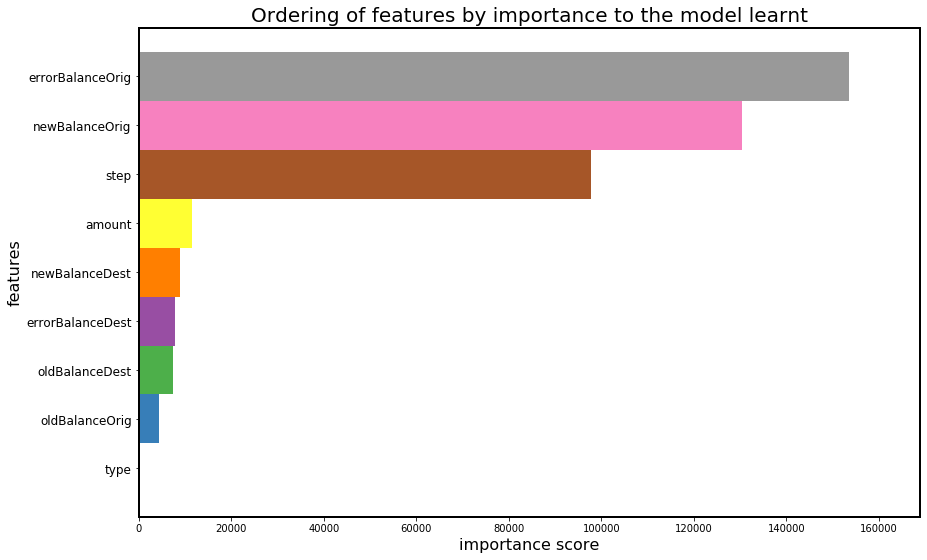

In [35]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);

here , Our created features work very well to define the answer so let's check our model presentation

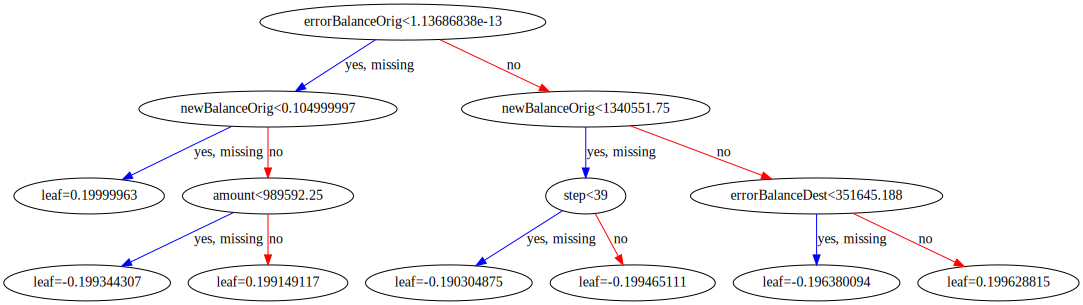

In [36]:
to_graphviz(clf)

# Bias-Variance Tradeoff

In [37]:

trainSizes, trainScores, crossValScores = learning_curve(\
XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4), X_train,\
                                         Y_train, scoring = 'average_precision')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


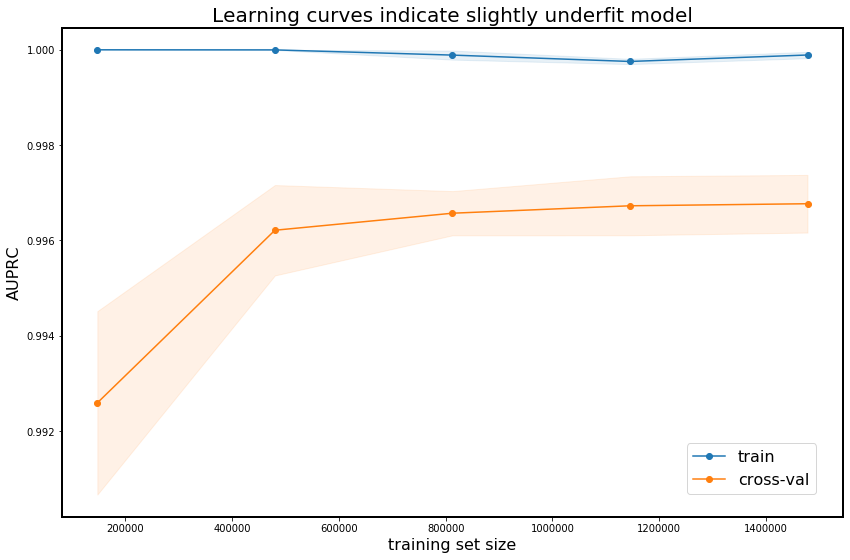

In [38]:
trainScoresMean = np.mean(trainScores, axis=1)
trainScoresStd = np.std(trainScores, axis=1)
crossValScoresMean = np.mean(crossValScores, axis=1)
crossValScoresStd = np.std(crossValScores, axis=1)

colours = plt.cm.tab10(np.linspace(0, 1, 9))

fig = plt.figure(figsize = (14, 9))
plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
    trainScoresMean + trainScoresStd, alpha=0.1, color=colours[0])
plt.fill_between(trainSizes, crossValScoresMean - crossValScoresStd,
    crossValScoresMean + crossValScoresStd, alpha=0.1, color=colours[1])
plt.plot(trainSizes, trainScores.mean(axis = 1), 'o-', label = 'train', \
         color = colours[0])
plt.plot(trainSizes, crossValScores.mean(axis = 1), 'o-', label = 'cross-val', \
         color = colours[1])


ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ['train', 'cross-val'], bbox_to_anchor=(0.8, 0.15), \
               loc=2, borderaxespad=0, fontsize = 16);
plt.xlabel('training set size', size = 16); 
plt.ylabel('AUPRC', size = 16)
plt.title('Learning curves indicate slightly underfit model', size = 20);


# Conclusion

Still the learning tradoff curve give us idea that it is underfit model becuase training cruve reduce with set training and acuracy percentatge for that are almost more thatn 99.5 % and cross validation also work best upto some level of data  10000000 and then it goes down so ...

Our curve gives better performance upto some extend then reduce performance show its weekness of train in good manner. from a lot of model this esembled model is one of the best model for such huge data. such tree algorithm with boosting performance will give best result for all such bunch of the dataset range. Thank you.

In [ ]:
# rerun file...